In [33]:
import numpy as np
import pandas as pd

from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
df_train = pd.read_csv('goodreads_train.csv')
df_test = pd.read_csv('goodreads_test.csv')
df_sub = pd.read_csv('goodreads_sample_submission.csv')

# Delete dublicate reviews and review_id
df_train.drop_duplicates(subset=["review_id"], inplace=True, keep='first')
df_train.drop_duplicates(subset=["review_text"], inplace=True, keep='first')

# Delete reviews with less than 5 letters.
indexReviewText = df_train.loc[ df_train['review_text'].str.len() <= 5].index
df_train.drop(indexReviewText , inplace=True)

# # Delete needless columns
df_train = df_train[['review_text','rating']]

# Clean the review data which consists of word greater than 30
get_word_length = lambda phrase: np.mean(list(map(len, phrase.split())))
condition = df_train.review_text.apply(get_word_length) > 30
index = df_train.index
bad_word_indices = index[condition].tolist()
df_train.drop(bad_word_indices,inplace=True)


In [21]:
# one-hot-encode my ratings variable
train_samp = pd.get_dummies(df_train, columns = ['rating'])
test_samp = pd.get_dummies(df_test, columns = ['rating'])
# the below test sample is used when we need get to create a output to submit in kaggle
# test_samp = df_test[['review_text']]

In [22]:
# GLoVe word vectors to get pretrained word embeddings
embed_size = 300 
# max number of unique words 
max_features = 30000
# max number of words from review to use
maxlen = 300

# File path
embedding_file = 'glove.840B.300d/glove.840B.300d.txt'

# read in embeddings
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split(' ')) for o in open(embedding_file, encoding="utf8"))

In [23]:
# get rating as array
class_names = ['rating_0', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
y = train_samp[class_names].values

In [24]:
# data tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['review_text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['review_text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['review_text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [25]:
# read in embeddings
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [26]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outc = Dense(24, activation='relu')(conc)
outp = Dense(6, activation = 'sigmoid')(outc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [27]:
hist = model.fit(x_train, y, batch_size = 62, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Epoch 1/20
4065/4065 [==============================] - 392s 93ms/step - loss: 0.3071 - accuracy: 0.5305 - val_loss: 0.2780 - val_accuracy: 0.5821
Epoch 2/20
4065/4065 [==============================] - 388s 95ms/step - loss: 0.2723 - accuracy: 0.5966 - val_loss: 0.2692 - val_accuracy: 0.5983
Epoch 3/20
4065/4065 [==============================] - 385s 95ms/step - loss: 0.2598 - accuracy: 0.6219 - val_loss: 0.2677 - val_accuracy: 0.6081
Epoch 4/20
4065/4065 [==============================] - 377s 93ms/step - loss: 0.2506 - accuracy: 0.6426 - val_loss: 0.2696 - val_accuracy: 0.6023
Epoch 5/20
4065/4065 [==============================] - 374s 92ms/step - loss: 0.2419 - accuracy: 0.6590 - val_loss: 0.2714 - val_accuracy: 0.6029
Epoch 6/20
4065/4065 [==============================] - 378s 93ms/step - loss: 0.2341 - accuracy: 0.6753 - val_loss: 0.2772 - val_accuracy: 0.6003


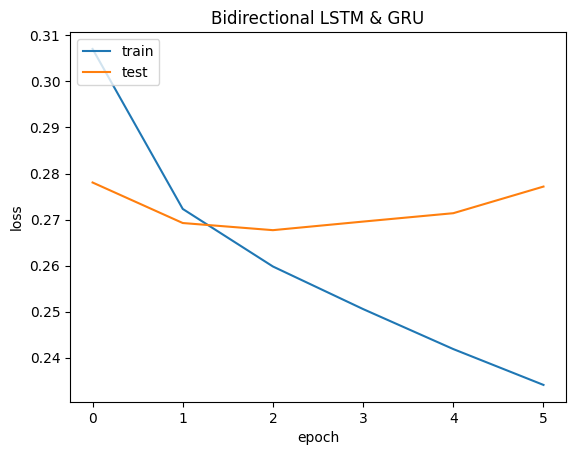

In [29]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Bidirectional LSTM & GRU')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     9000000     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 300, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 300, 80)      109120      ['spatial_dropout1d[0][0]']  

In [14]:
y_test = model.predict([x_test], batch_size=1024,verbose=1)


69/69 [==============================] - 5s 71ms/step


In [12]:
# Save the prediction in csv format to submit in kaggle
# rating_pred = []
# for ratings in y_test:
#     result = np.where(ratings == np.amax(ratings))
#     rating_pred.append(result[0][0])

# df_sub.rating = rating_pred
# df_sub.to_csv("submission.csv", index=False)

In [15]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)


69/69 [==============================] - 5s 69ms/step - loss: 0.2770 - accuracy: 0.5984


[0.2769937217235565, 0.5984428524971008]

In [16]:
# Quality metrics
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.56      0.35      0.43      2336
           1       0.46      0.48      0.47      2132
           2       0.52      0.43      0.47      5748
           3       0.56      0.57      0.56     14557
           4       0.59      0.59      0.59     24572
           5       0.66      0.72      0.69     20655

    accuracy                           0.60     70000
   macro avg       0.56      0.52      0.54     70000
weighted avg       0.60      0.60      0.60     70000

